### Modelling

In [1]:
#importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19, DenseNet121

from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
#setting the trai and test directories
train_dir="C:/Users/HP/Downloads/case study2/DATASET/TRAIN"
test_dir="C:/Users/HP/Downloads/case study2/DATASET/TEST"

In [3]:
#Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(256,256),
                                                    shuffle=True)


test_generator = test_datagen.flow_from_directory(test_dir,
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(256,256),
                                                    shuffle=False)

Found 1168 images belonging to 6 classes.
Found 486 images belonging to 6 classes.


In [15]:
train_generator.class_indices

{'downdog': 0,
 'goddess': 1,
 'plank': 2,
 'standing': 3,
 'tree': 4,
 'warrior2': 5}

In [16]:
test_generator.class_indices

{'downdog': 0,
 'goddess': 1,
 'plank': 2,
 'standing': 3,
 'tree': 4,
 'warrior2': 5}

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

### Using pre-trained VGG19 model with Imagenet weights to extract the feature vectors and adding some dense layers to predict the pose.

In [18]:
def custom_model():
    cus_model = VGG19(input_shape = (256,256,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = Flatten()(cus_model.output)

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(6, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [19]:
model = custom_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("yoga_model_vgg19.h5", save_best_only=True,monitor='val_loss')

# Early stopping callback
early_stopping_m = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[checkpoint_cb, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
73/73 [==============================] - 41s 527ms/step - loss: 1.4428 - accuracy: 0.5985 - val_loss: 0.2428 - val_accuracy: 0.9259
Epoch 2/30
73/73 [==============================] - 34s 459ms/step - loss: 0.4680 - accuracy: 0.8442 - val_loss: 0.1761 - val_accuracy: 0.9342
Epoch 3/30
73/73 [==============================] - 35s 479ms/step - loss: 0.3244 - accuracy: 0.8930 - val_loss: 0.2707 - val_accuracy: 0.9218
Epoch 4/30
73/73 [==============================] - 39s 537ms/step - loss: 0.2257 - accuracy: 0.9366 - val_loss: 0.1327 - val_accuracy: 0.9486
Epoch 5/30
73/73 [==============================] - 39s 528ms/step - loss: 0.1298 - accuracy: 0.9589 - val_loss: 0.1643 - val_accuracy: 0.9506
Epoch 6/30
73/73 [==============================] - 31s 419ms/step - loss: 0.1064 - accuracy: 0.9692 - val_loss: 0.1263 - val_accuracy: 0.9630
Epoch 7/30
73/73 [==============================] - 28s 378ms/step - loss: 0.0779 - accuracy: 0.9795 - val_loss: 0.2473 - val_accuracy: 0.9321

<Figure size 432x288 with 0 Axes>

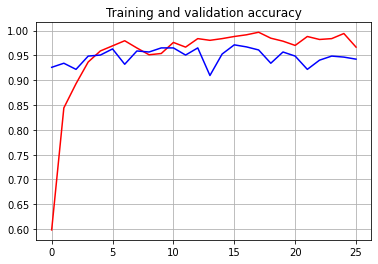

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

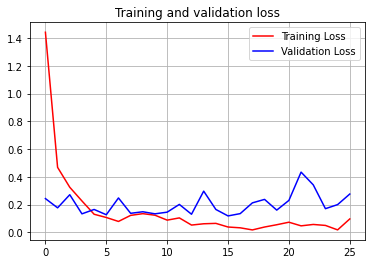

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    
    labels = ['downdog', 'tree','standing','warrior2', 'goddess', 'plank']
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  5.761316872427984
-------------------------------------------------- Confusion matrix --------------------------------------------------


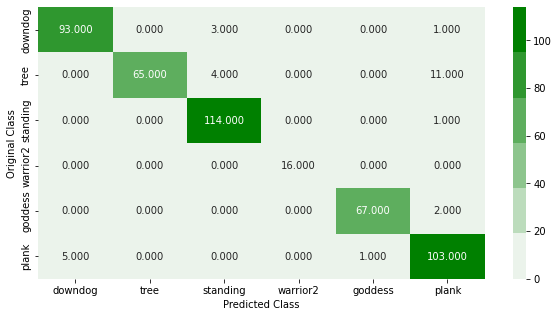

-------------------------------------------------- Precision matrix --------------------------------------------------


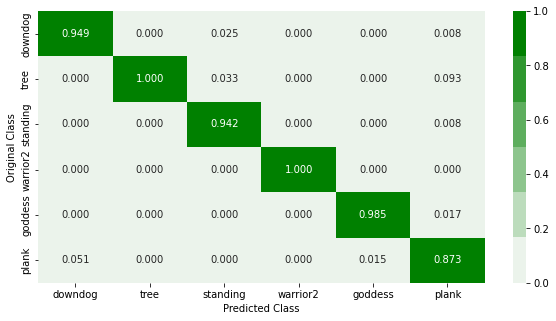

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


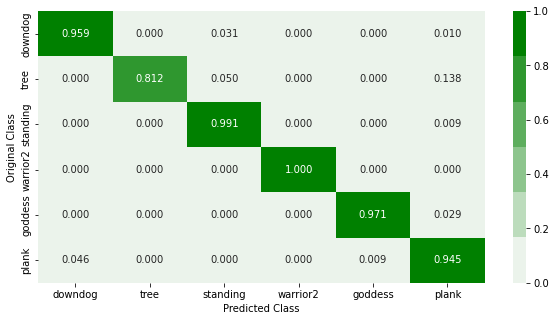

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]
None


In [24]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(plot_confusion_matrix(test_generator.classes, y_pred))

### Observations:
1. seems like our model is slightly overfitting.
2. We will try adding dropout and reduced learning rate
3. Any how our model performed good. And got good precision and recall.

In [25]:
def custom_model():
    cus_model = VGG19(input_shape = (256,256,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = Flatten()(cus_model.output)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [26]:
model2=custom_model()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [27]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("yoga_model_vgg19_dropout.h5", save_best_only=True,monitor='val_loss')

# Early stopping callback
early_stopping_m = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,  min_lr=0.00001)

history = model2.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[checkpoint_cb, early_stopping_m, lr_reduction],
                    verbose=1
                    )

Epoch 1/30
 2/73 [..............................] - ETA: 15s - loss: 8.3427 - accuracy: 0.1562 

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


73/73 [==============================] - 34s 456ms/step - loss: 3.0745 - accuracy: 0.5599 - val_loss: 0.2924 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 2/30
73/73 [==============================] - 33s 456ms/step - loss: 0.5755 - accuracy: 0.8048 - val_loss: 0.2218 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 3/30
73/73 [==============================] - 33s 452ms/step - loss: 0.3870 - accuracy: 0.8887 - val_loss: 0.2076 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 4/30
73/73 [==============================] - 33s 455ms/step - loss: 0.2973 - accuracy: 0.9075 - val_loss: 0.1295 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/30
73/73 [==============================] - 33s 450ms/step - loss: 0.2743 - accuracy: 0.9075 - val_loss: 0.2281 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 6/30
73/73 [==============================] - 33s 445ms/step - loss: 0.2110 - accuracy: 0.9281 - val_loss: 0.1691 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 7/30
73/73 [==============================] - 33s 448ms/step - loss: 

<Figure size 432x288 with 0 Axes>

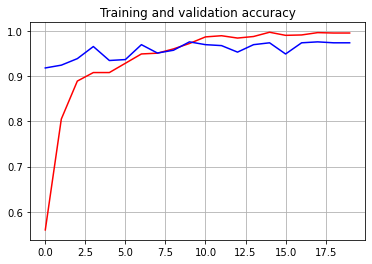

<Figure size 432x288 with 0 Axes>

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

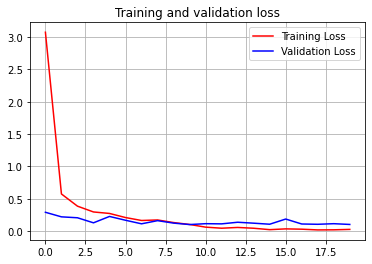

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

Number of misclassified points  5.761316872427984
-------------------------------------------------- Confusion matrix --------------------------------------------------


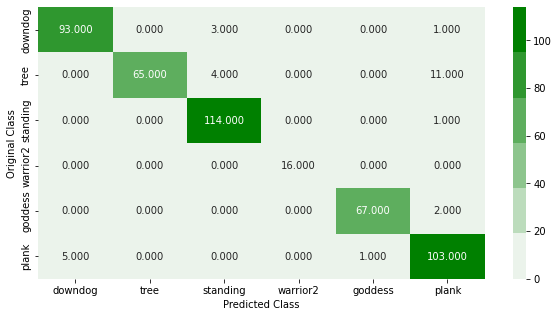

-------------------------------------------------- Precision matrix --------------------------------------------------


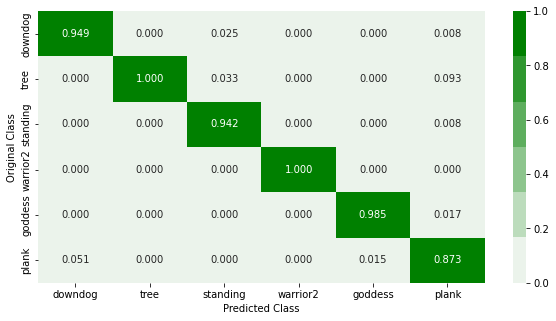

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


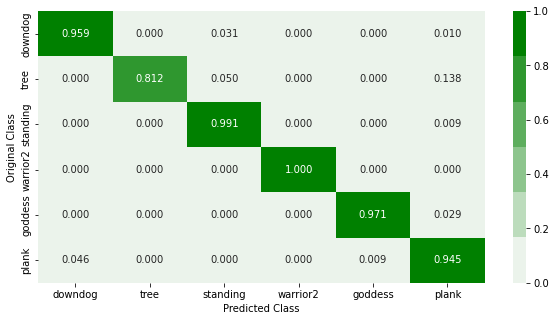

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]
None


In [30]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(plot_confusion_matrix(test_generator.classes, y_pred))

### Observations:
1. we can see model achieved good precision and recall.
2. there is a small confusion between tree and plank.

### Lets try with pretarined DenseNet121 model

In [31]:
def custom_model():
    cus_model = DenseNet121(input_shape = (256,256,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = Flatten()(cus_model.output)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [32]:
model3=custom_model()
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 32, 32, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 16, 16, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 16, 16, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 16, 16, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 8, 8, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 8, 8, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 8, 8, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 8, 8, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 8, 8, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 8, 8, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

Total params: 40,595,526
Trainable params: 33,558,022
Non-trainable params: 7,037,504
__________________________________________________________________________________________________


In [33]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("yoga_model_Densenet121_dropout.h5", save_best_only=True,monitor='val_loss')

# Early stopping callback
early_stopping_m = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,  min_lr=0.00001)

history = model3.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[checkpoint_cb, early_stopping_m, lr_reduction],
                    verbose=1
                    )

Epoch 1/30
 7/73 [=>............................] - ETA: 17s - loss: 37.2090 - accuracy: 0.2857

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


73/73 [==============================] - 43s 494ms/step - loss: 10.3222 - accuracy: 0.6430 - val_loss: 0.3578 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 2/30
73/73 [==============================] - 32s 439ms/step - loss: 0.5509 - accuracy: 0.8682 - val_loss: 0.2067 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 3/30
73/73 [==============================] - 33s 445ms/step - loss: 0.2377 - accuracy: 0.9264 - val_loss: 0.1465 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 4/30
73/73 [==============================] - 32s 442ms/step - loss: 0.2270 - accuracy: 0.9332 - val_loss: 0.1444 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 5/30
73/73 [==============================] - 31s 418ms/step - loss: 0.1868 - accuracy: 0.9375 - val_loss: 0.1494 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 6/30
73/73 [==============================] - 30s 416ms/step - loss: 0.1386 - accuracy: 0.9478 - val_loss: 0.1613 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 7/30
73/73 [==============================] - 29s 403ms/step - loss:

<Figure size 432x288 with 0 Axes>

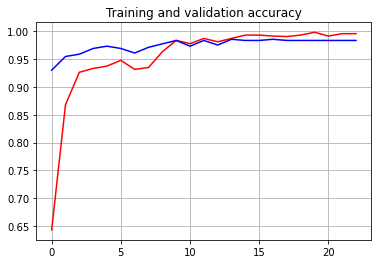

<Figure size 432x288 with 0 Axes>

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

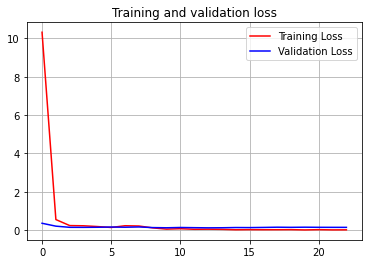

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

Number of misclassified points  5.761316872427984
-------------------------------------------------- Confusion matrix --------------------------------------------------


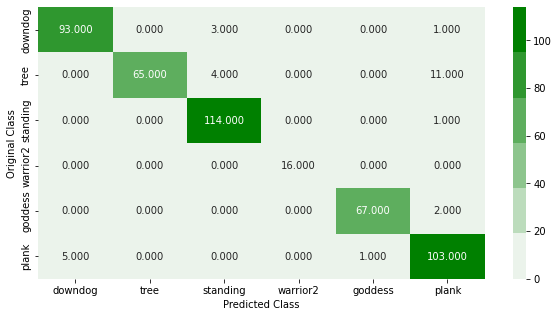

-------------------------------------------------- Precision matrix --------------------------------------------------


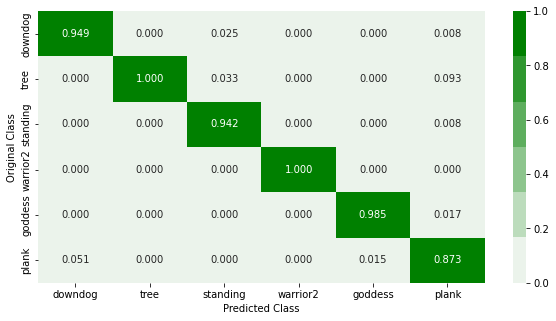

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


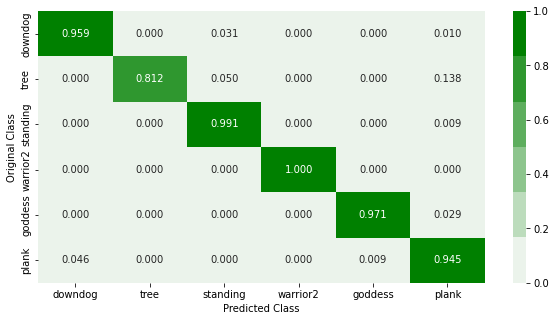

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]
None


In [36]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(plot_confusion_matrix(test_generator.classes, y_pred))

### Observations:
1. we can see both models gave almost same results.
2. we achieved good precision and recall.
3. we can go for predicting pose with these models.